In [34]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install text-unidecode

# ## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[asr]

## Install TorchAudio
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


^C
Looking in links: https://download.pytorch.org/whl/torch_stable.html


  Cloning https://github.com/NVIDIA/NeMo.git (to revision main) to c:\users\rakin\appdata\local\temp\pip-install-d2vutkvr\nemo-toolkit_bdb9df37a18a4e038a7ea70c21c6ce6b
  Resolved https://github.com/NVIDIA/NeMo.git to commit 008e5a05721bc38605ab714a7252949ae639779f
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


DEPRECATION: git+https://github.com/NVIDIA/NeMo.git@main#egg=nemo_toolkit[asr] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA/NeMo.git 'C:\Users\rakin\AppData\Local\Temp\pip-install-d2vutkvr\nemo-toolkit_bdb9df37a18a4e038a7ea70c21c6ce6b'


### A toy example for speaker diarization

Download a toy example audio file (`an4_diarize_test.wav`) and its ground-truth label file (`an4_diarize_test.rttm`).

In [ ]:
import os
import wget
ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'data')
os.makedirs(data_dir, exist_ok=True)
an4_audio = os.path.join(data_dir,'an4_diarize_test.wav')
an4_rttm = os.path.join(data_dir,'an4_diarize_test.rttm')
if not os.path.exists(an4_audio):
    an4_audio_url = "https://nemo-public.s3.us-east-2.amazonaws.com/an4_diarize_test.wav"
    an4_audio = wget.download(an4_audio_url, data_dir)
if not os.path.exists(an4_rttm):
    an4_rttm_url = "https://nemo-public.s3.us-east-2.amazonaws.com/an4_diarize_test.rttm"
    an4_rttm = wget.download(an4_rttm_url, data_dir)

Let's plot and listen to the audio and visualize the RTTM speaker labels.

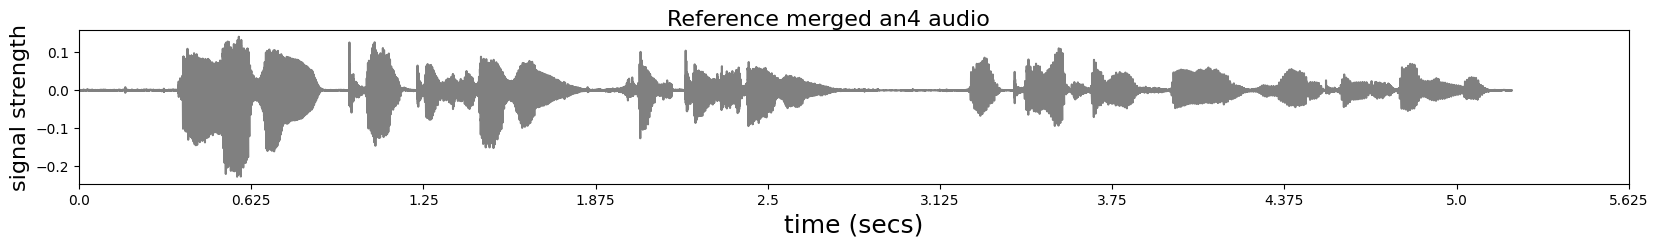

In [ ]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import librosa

sr = 16000
signal, sr = librosa.load(an4_audio,sr=sr) 

fig,ax = plt.subplots(1,1)
fig.set_figwidth(20)
fig.set_figheight(2)
plt.plot(np.arange(len(signal)),signal,'gray')
fig.suptitle('Reference merged an4 audio', fontsize=16)
plt.xlabel('time (secs)', fontsize=18)
ax.margins(x=0)
plt.ylabel('signal strength', fontsize=16);
a,_ = plt.xticks();plt.xticks(a,a/sr);

IPython.display.Audio(an4_audio)

We would use [pyannote_metrics](https://pyannote.github.io/pyannote-metrics/) for visualization and score calculation purposes. Hence all the labels in rttm formats would eventually be converted to pyannote objects, we created two helper functions rttm_to_labels (for NeMo intermediate processing) and labels_to_pyannote_object for scoring and visualization format.

In [ ]:
from nemo.collections.asr.parts.utils.speaker_utils import rttm_to_labels, labels_to_pyannote_object

Let's load ground truth RTTM labels and view the reference Annotation timestamps visually

In [ ]:
# view the sample rttm file
!cat {an4_rttm}

'cat' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
labels = rttm_to_labels(an4_rttm)
reference = labels_to_pyannote_object(labels)
print(labels)


['0.299 2.77 A', '3.164 5.147 B']


In [ ]:
# Create a manifest for input with below format. 
# {'audio_filepath': /path/to/audio_file, 'offset': 0, 'duration':None, 'label': 'infer', 'text': '-', 
# 'num_speakers': None, 'rttm_filepath': /path/to/rttm/file, 'uem_filepath'='/path/to/uem/filepath'}
import json
meta = {
    'audio_filepath': an4_audio, 
    'offset': 0, 
    'duration':None, 
    'label': 'infer', 
    'text': '-', 
    'num_speakers': 2, 
    'rttm_filepath': an4_rttm, 
    'uem_filepath' : None
}
with open('data/input_manifest.json','w') as fp:
    json.dump(meta,fp)
    fp.write('\n')

!cat data/input_manifest.json

output_dir = os.path.join(ROOT, 'oracle_vad')
os.makedirs(output_dir,exist_ok=True)

'cat' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
from omegaconf import OmegaConf
MODEL_CONFIG = os.path.join(data_dir,'diar_infer_telephonic.yaml')
if not os.path.exists(MODEL_CONFIG):
    config_url = "https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/diarization/conf/inference/diar_infer_telephonic.yaml"
    MODEL_CONFIG = wget.download(config_url,data_dir)

config = OmegaConf.load(MODEL_CONFIG)
print(OmegaConf.to_yaml(config))

name: ClusterDiarizer
num_workers: 1
sample_rate: 16000
batch_size: 64
device: null
verbose: true
diarizer:
  manifest_filepath: ???
  out_dir: ???
  oracle_vad: false
  collar: 0.25
  ignore_overlap: true
  vad:
    model_path: vad_multilingual_marblenet
    external_vad_manifest: null
    parameters:
      window_length_in_sec: 0.15
      shift_length_in_sec: 0.01
      smoothing: median
      overlap: 0.5
      onset: 0.1
      offset: 0.1
      pad_onset: 0.1
      pad_offset: 0
      min_duration_on: 0
      min_duration_off: 0.2
      filter_speech_first: true
  speaker_embeddings:
    model_path: titanet_large
    parameters:
      window_length_in_sec:
      - 1.5
      - 1.25
      - 1.0
      - 0.75
      - 0.5
      shift_length_in_sec:
      - 0.75
      - 0.625
      - 0.5
      - 0.375
      - 0.25
      multiscale_weights:
      - 1
      - 1
      - 1
      - 1
      - 1
      save_embeddings: true
  clustering:
    parameters:
      oracle_num_speakers: false
      max

Now we can perform speaker diarization based on timestamps generated from ground truth rttms rather than generating through VAD. 

Let's set parameters for speaker diarization inference. We will use `titanet_large` speaker embedding model for running clustering diarizer. 

In [ ]:
config.diarizer.manifest_filepath = 'data/input_manifest.json'
config.diarizer.out_dir = output_dir # Directory to store intermediate files and prediction outputs
pretrained_speaker_model = 'titanet_large'
config.diarizer.speaker_embeddings.model_path = pretrained_speaker_model
config.diarizer.speaker_embeddings.parameters.window_length_in_sec = [1.5,1.25,1.0,0.75,0.5] 
config.diarizer.speaker_embeddings.parameters.shift_length_in_sec = [0.75,0.625,0.5,0.375,0.1] 
config.diarizer.speaker_embeddings.parameters.multiscale_weights= [1,1,1,1,1] 
config.diarizer.oracle_vad = True # ----> ORACLE VAD 
config.diarizer.clustering.parameters.oracle_num_speakers = False

### Clustering Diarizer: with Oracle VAD

Now that we set configurations, import `ClusteringDiarizer` class and create a clustering diarizer instance.

In [ ]:
from nemo.collections.asr.models import ClusteringDiarizer
oracle_vad_clusdiar_model = ClusteringDiarizer(cfg=config)

[NeMo I 2024-05-29 19:57:18 clustering_diarizer:157] Loading pretrained titanet_large model from NGC
[NeMo I 2024-05-29 19:57:18 cloud:58] Found existing object C:\Users\rakin\.cache\torch\NeMo\NeMo_2.0.0rc1\titanet-l\11ba0924fdf87c049e339adbf6899d48\titanet-l.nemo.
[NeMo I 2024-05-29 19:57:18 cloud:64] Re-using file from: C:\Users\rakin\.cache\torch\NeMo\NeMo_2.0.0rc1\titanet-l\11ba0924fdf87c049e339adbf6899d48\titanet-l.nemo
[NeMo I 2024-05-29 19:57:18 common:826] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-29 19:57:18 modelPT:176] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2024-05-29 19:57:18 modelPT:183] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method 

[NeMo I 2024-05-29 19:57:18 features:305] PADDING: 16
[NeMo I 2024-05-29 19:57:19 save_restore_connector:263] Model EncDecSpeakerLabelModel was successfully restored from C:\Users\rakin\.cache\torch\NeMo\NeMo_2.0.0rc1\titanet-l\11ba0924fdf87c049e339adbf6899d48\titanet-l.nemo.


In [ ]:
# And lets diarize
oracle_vad_clusdiar_model.diarize()

[NeMo W 2024-05-29 19:57:22 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-29 19:57:22 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-29 19:57:22 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, c:\Users\rakin\Documents\GitHub\Speaker-Diarization\Main code\oracle_vad\speaker_outputs\subsegments_scale0.json
[NeMo I 2024-05-29 19:57:22 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-29 19:57:22 collections:732] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-29 19:57:22 collections:733] Dataset loaded with 5 items, total duration of  0.00 hours.
[NeMo I 2024-05-29 19:57:22 collections:735] # 5 files loaded accounting to # 1 labels


[1/5] extract embeddings:   0%|          | 0/1 [00:00<?, ?it/s]


PicklingError: Can't pickle <class 'nemo.collections.common.parts.preprocessing.collections.SpeechLabelEntity'>: attribute lookup SpeechLabelEntity on nemo.collections.common.parts.preprocessing.collections failed

With DER 0 -> means it clustered speaker embeddings correctly. Let's view 

In [ ]:
!cat {output_dir}/pred_rttms/an4_diarize_test.rttm

Visualize the diarization output of clustering diarizer and compare with the ground-truth speaker labels.

In [ ]:
print("Clustering Diarizer Result (RTTM format)")
pred_labels_neural = rttm_to_labels(f'{output_dir}/pred_rttms/an4_diarize_test.rttm')
hypothesis_neural = labels_to_pyannote_object(pred_labels_neural)
hypothesis_neural

Clustering Diarizer Result (RTTM format)


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\rakin\\Documents\\GitHub\\Speaker-Diarization\\Main code\\oracle_vad/pred_rttms/an4_diarize_test.rttm'

In [ ]:
print("Ground-truth Speaker Labels")
reference

### Neural Diarizer: Multiscale Diarization Decoder with Oracle VAD

The checkpoints (`.ckpt`) or NeMo files (`.nemo`) for **neural diarizers** contain all the necessary neural models for speaker diarization. For example, an MSDD model checkpoint or a NeMo file has pre-trained [TitaNet](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/titanet_large) and MSDD model itself. 

In this tutorial, we use [diar_msdd_telephonic](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/diar_msdd_telephonic) which is optimized for telephic speech. Since we share the same YAML file for all kinds of speaker diarization inference, all we need to do is add model path on top of the config setting for clustering diarizer.

`sigmoid_threshold` is a threshold for making the final binary decision on overlapping speaker label. The lower the value is, the more generous on the speech overlap detection. `sigmoid_threshold` value affects false alarm and miss errors. Default value is `0.7` for telephonic model and if `sigmoid_threshold=1.0`, no overlap speech is detected.

In [ ]:
config.diarizer.msdd_model.model_path = 'diar_msdd_telephonic' # Telephonic speaker diarization model 
config.diarizer.msdd_model.parameters.sigmoid_threshold = [0.7, 1.0] # Evaluate with T=0.7 and T=1.0

In [ ]:
from nemo.collections.asr.models.msdd_models import NeuralDiarizer
oracle_vad_msdd_model = NeuralDiarizer(cfg=config)

Unlike clustering diarizer, neural diarizer evaluates diarization results in three different settings by default:

* `collar=0.25`, `ignore_overlap=True`: This is the default setting for evaluating clustering diarizer.
* `collar=0.25`, `ignore_overlap=False`: Still 0.25 s around boundaries are not evaluated but overlaps are evaluated.
* `collar=0.0`, `ignore_overlap=False`: No collar at all and evaluate overlaps. 

Let's run the MSDD model with the prepared configurations.

In [ ]:
oracle_vad_msdd_model.diarize()

The output of the neural diarizer is saved in `outputs/pred_rttms`.

In [ ]:
!cat {output_dir}/pred_rttms/an4_diarize_test.rttm

Visualize the diarization output of clustering diarizer and compare with the ground-truth speaker labels.

In [ ]:
print("Neural Diarizer Result (RTTM format)")
pred_labels_neural = rttm_to_labels(f'{output_dir}/pred_rttms/an4_diarize_test.rttm')
hypothesis_neural = labels_to_pyannote_object(pred_labels_neural)
hypothesis_neural

In [ ]:
print("Ground-truth Speaker Labels")
reference

# Speaker Diarization with System VAD (NeMo VAD models)

In this section, we actually compute VAD timestamps using a NeMo VAD model on the input manifest file. Next, we use these timestamps for speech/non-speech labels to extract speaker embedding vectors followed by clustering them into num of speakers. As opposed to oracle VAD, the result from an actual VAD model is referred to as __system VAD__.

Before we proceed let's look at the speaker diarization config, which we would be depending up on for vad computation
and speaker embedding extraction.

In [ ]:
print(OmegaConf.to_yaml(config))

As can be seen most of the variables in config are self explanatory 
with VAD variables under vad section and speaker related variables under speaker embeddings section. 

To perform VAD based diarization we can ignore `oracle_vad_manifest` in `speaker_embeddings` key for now and need to fill up the rest. We also needs to provide pretrained `model_path` of vad and speaker embeddings .nemo models.

In [ ]:
pretrained_vad = 'vad_multilingual_marblenet'
pretrained_speaker_model = 'titanet_large'

Note in this tutorial, we use the VAD model *vad_multilingual_marblenet* which is an improved model based on MarbleNet-3x2 that has been introduced and published in [ICASSP MarbleNet](https://arxiv.org/pdf/2010.13886.pdf). You might need to tune on dev set similar to your dataset if you would like to improve the performance.

And the speakerNet-M-Diarization model achieves 7.3% confusion error rate on CH109 set with oracle vad. This model is trained on voxceleb1, voxceleb2, Fisher, SwitchBoard datasets. So for more improved performance specific to your dataset, finetune speaker verification model with a devset similar to your test set.

It is recommended to set `num_workers=1` since using the multiprocessing package in Jupyter Notebook environment might cause freezing issues. For sizable data, run speaker diarization using the scripts in `NeMo/examples/speaker_tasks/` setting `num_workers` larger than 1 in the configurations.

You can play with parameters in configurations as below.

In [ ]:
config.num_workers = 0 # Workaround for multiprocessing hanging with ipython issue 

output_dir = os.path.join(ROOT, 'outputs')
config.diarizer.manifest_filepath = 'data/input_manifest.json'
config.diarizer.out_dir = output_dir #Directory to store intermediate files and prediction outputs

config.diarizer.speaker_embeddings.model_path = pretrained_speaker_model
config.diarizer.oracle_vad = False # compute VAD provided with model_path to vad config
config.diarizer.clustering.parameters.oracle_num_speakers=False

# Here, we use our in-house pretrained NeMo VAD model
config.diarizer.vad.model_path = pretrained_vad
config.diarizer.vad.parameters.onset = 0.8
config.diarizer.vad.parameters.offset = 0.6
config.diarizer.vad.parameters.pad_offset = -0.05

NameError: name 'pretrained_vad' is not defined

### Clustering Diarizer: with System VAD

Now that we passed all the variables we need, let's initialize the clustering diarizer model with the configurations we set. 

In [ ]:
from nemo.collections.asr.models import ClusteringDiarizer
sd_model = ClusteringDiarizer(cfg=config)

And launch diarization with a single line of code.

In [ ]:
sd_model.diarize()

As can be seen, we first performed VAD, then with the timestamps created in `{output_dir}/vad_outputs` by VAD we calculated speaker embeddings (`{output_dir}/speaker_outputs/embeddings/`) which are then clustered using spectral clustering. 

Generating predicted  VAD timesteps: We perform VAD inference to have frame level prediction &#8594; (optional: use decision smoothing) &#8594; given `threshold`,  write speech segments to a RTTM-like timestamp manifest file.

We use VAD decision smoothing (50% overlap median) as described in [vad_utils.py](https://github.com/NVIDIA/NeMo/blob/stable/nemo/collections/asr/parts/utils/vad_utils.py).

You can also tune the threshold on your dev set. Use this provided in [vad_tune_threshold.py](https://github.com/NVIDIA/NeMo/blob/stable/scripts/voice_activity_detection/vad_tune_threshold.py).

In [ ]:
# VAD predicted time stamps
# you can also use single threshold(=onset=offset) for binarization and plot here
from nemo.collections.asr.parts.utils.vad_utils import plot

if config.diarizer.vad.parameters.smoothing:
    vad_output_filepath = f'{output_dir}/vad_outputs/overlap_smoothing_output_median_{config.diarizer.vad.parameters.overlap}/an4_diarize_test.{config.diarizer.vad.parameters.smoothing}'
else:
    vad_output_filepath = f'{output_dir}/vad_outputs/an4_diarize_test.frame'

plot(
    an4_audio,
    vad_output_filepath, 
    an4_rttm,
    per_args = config.diarizer.vad.parameters, #threshold
    ) 

print(f"VAD params:{OmegaConf.to_yaml(config.diarizer.vad.parameters)}")

Predicted outputs are written to `{output_dir}/pred_rttms` and see how we predicted along with VAD prediction

In [ ]:
!cat {output_dir}/pred_rttms/an4_diarize_test.rttm

Visualize the diarization output of clustering diarizer and compare with the ground-truth speaker labels.

In [ ]:
print("Clustering Diarizer Result (RTTM format)")
pred_labels_neural = rttm_to_labels(f'{output_dir}/pred_rttms/an4_diarize_test.rttm')
hypothesis_neural = labels_to_pyannote_object(pred_labels_neural)
hypothesis_neural


In [ ]:
print("Ground-truth Speaker Labels (RTTM format)")
reference

### Neural Diarizer: Multiscale Diarization Decoder with System VAD

We can run a neural diarizer model without changing many parameters since neural diarizer also performs VAD and clustering diarizer. All we need to do is run the MSDD model with the new config file.

In [ ]:
config.diarizer.msdd_model.model_path = 'diar_msdd_telephonic' # Telephonic speaker diarization model 
config.diarizer.msdd_model.parameters.sigmoid_threshold = [0.7, 1.0] # Evaluate with T=0.7 and T=1.0
system_vad_msdd_model = NeuralDiarizer(cfg=config)

In [ ]:
system_vad_msdd_model.diarize()

Check whether diarization saved in `outputs/pred_rttms` is correct.

In [ ]:
!cat {output_dir}/pred_rttms/an4_diarize_test.rttm

Visualize the diarization output of clustering diarizer and compare with the ground-truth speaker labels.

In [ ]:
print("Neural Diarizer Result (RTTM format)")
pred_labels_neural = rttm_to_labels(f'{output_dir}/pred_rttms/an4_diarize_test.rttm')
hypothesis_neural = labels_to_pyannote_object(pred_labels_neural)
hypothesis_neural

In [ ]:
print("Ground-truth Speaker Labels (RTTM format)")
reference

# Storing and Restoring models

For clustering diarizer, we can save the whole config and model parameters in a single .nemo and restore from it anytime. Neural diarizer will support this feature soon.

In [ ]:
oracle_vad_clusdiar_model.save_to(os.path.join(output_dir,'clustering_diarizer.nemo'))

Restore from saved model

In [ ]:
del oracle_vad_clusdiar_model
import nemo.collections.asr as nemo_asr
restored_model = nemo_asr.models.ClusteringDiarizer.restore_from(os.path.join(output_dir,'clustering_diarizer.nemo'))